In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


MODEL_SAVE_FOLDER = '/content/drive/My Drive/Colab Notebooks/capstone2-DL'

def getData(path=MODEL_SAVE_FOLDER+'/images/', num_each=1000):
    data = []
    class_num = -1

    for idx, (root, dirs, files) in enumerate(os.walk(path)):
      num = 0
      
      if root == path:
        class_num = len(dirs)
        continue

      label = np.zeros(class_num)
      label[idx - 1] = 1

      for fname in files:
        num += 1
        if num > num_each:
          break
        full_fname = os.path.join(root, fname)
        data.append([full_fname, label])
        # print("success", full_fname)

    return np.array(data)

In [0]:
IMG_SIZE = 224
CHANNELS = 3

In [0]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [0]:
def create_dataset(filenames, labels, is_training=True, batch_size=256, 
                   autotune=tf.data.experimental.AUTOTUNE, 
                   shuffle_buffer_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=autotune)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=autotune)
    
    return dataset

In [0]:
from tensorflow.keras import layers
import tensorflow_hub as hub


def create_model(n_labels = 13):
  feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
  feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
  feature_extractor_layer.trainable = False

  model = tf.keras.Sequential([feature_extractor_layer, 
                               layers.Dense(1024, activation='relu', name='hidden_layer_1'),
                               layers.Dense(512, activation='relu', name='hidden_layer_2'),
                               layers.Dense(n_labels, activation='sigmoid', name='output')])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=macro_double_soft_f1,
              metrics=[macro_f1, 'accuracy'])
  return model

In [0]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    
    return macro_f1

In [0]:
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
# This is the TPU initialization code that has to be at the beginning.

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [28]:
# tpu
# with strategy.scope():
#   model = create_model()
#   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                 loss=macro_double_soft_f1,
#                 metrics=[macro_f1])

# gpu
model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1024)              1311744   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 13)                6669      
Total params: 4,101,197
Trainable params: 1,843,213
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split


data = getData(num_each=1000)

X_data = data[:, 0].tolist()
y_data = data[:, 1].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=321)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 123)

train_ds = create_dataset(X_train, y_train)
test_ds = create_dataset(X_test, y_test)
val_ds = create_dataset(X_val, y_val)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime


# checkpoint_path = MODEL_SAVE_FOLDER + '/training/{epoch:04d}-{val_loss:.4f}.ckpt'
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = MODEL_SAVE_FOLDER + '/models/soft-f1_{}_best_pat50.h5'.format(t)

cp_callback = ModelCheckpoint(
    filepath=export_path, 
    monitor='val_loss',
    mode='min',
    save_best_only=True)

es_callback = EarlyStopping(patience=50)

In [31]:
history = model.fit(train_ds, 
                    epochs=1000, 
                    callbacks=[cp_callback, es_callback], 
                    validation_data=val_ds, 
                    verbose=2)

Epoch 1/1000
7/7 - 4s - loss: 0.5886 - macro_f1: 0.0971 - accuracy: 0.0654 - val_loss: 0.5766 - val_macro_f1: 0.1010 - val_accuracy: 0.0752
Epoch 2/1000
7/7 - 2s - loss: 0.5705 - macro_f1: 0.0833 - accuracy: 0.0765 - val_loss: 0.5610 - val_macro_f1: 0.0848 - val_accuracy: 0.0936
Epoch 3/1000
7/7 - 2s - loss: 0.5541 - macro_f1: 0.0640 - accuracy: 0.0820 - val_loss: 0.5435 - val_macro_f1: 0.0629 - val_accuracy: 0.1046
Epoch 4/1000
7/7 - 2s - loss: 0.5402 - macro_f1: 0.0490 - accuracy: 0.0960 - val_loss: 0.5335 - val_macro_f1: 0.0437 - val_accuracy: 0.1046
Epoch 5/1000
7/7 - 2s - loss: 0.5280 - macro_f1: 0.0344 - accuracy: 0.1089 - val_loss: 0.5216 - val_macro_f1: 0.0272 - val_accuracy: 0.1101
Epoch 6/1000
7/7 - 2s - loss: 0.5183 - macro_f1: 0.0169 - accuracy: 0.1248 - val_loss: 0.5108 - val_macro_f1: 0.0065 - val_accuracy: 0.1303
Epoch 7/1000
7/7 - 2s - loss: 0.5105 - macro_f1: 0.0118 - accuracy: 0.1456 - val_loss: 0.5078 - val_macro_f1: 0.0037 - val_accuracy: 0.1376
Epoch 8/1000
7/7 - 2

In [32]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 69ms/step - loss: 0.3280 - macro_f1: 0.3934 - accuracy: 0.5641


[0.3280255198478699, 0.3934321105480194, 0.5641025900840759]

In [0]:
# from datetime import datetime


# t = datetime.now().strftime("%Y%m%d_%H%M%S")
# export_path = MODEL_SAVE_FOLDER + '/models/soft-f1_{}.h5'.format(t)
# model.save(export_path)

# print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

In [0]:
loaded_model = tf.keras.models.load_model(export_path, 
                                  custom_objects={'KerasLayer':hub.KerasLayer, 
                                                  'macro_double_soft_f1':macro_double_soft_f1,
                                                  'macro_f1':macro_f1})

In [35]:
loaded_model.evaluate(test_ds)

3/3 [==============================] - 0s 70ms/step - loss: 0.3369 - macro_f1: 0.3883 - accuracy: 0.5641


[0.33687901496887207, 0.38825690746307373, 0.5641025900840759]

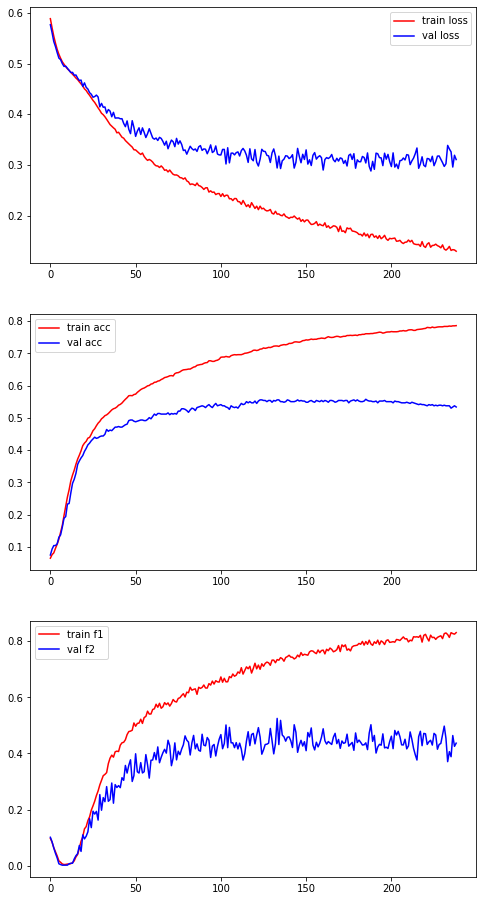

In [36]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 16))
plt.subplot(311)
plt.plot(history.history['loss'], color='r', label='train loss')
plt.plot(history.history['val_loss'], color='b', label='val loss')
plt.legend()
plt.subplot(312)
plt.plot(history.history['accuracy'], color='r', label='train acc')
plt.plot(history.history['val_accuracy'], color='b', label='val acc')
plt.legend()
plt.subplot(313)
plt.plot(history.history['macro_f1'], color='r', label='train f1')
plt.plot(history.history['val_macro_f1'], color='b', label='val f2')
plt.legend()

In [0]:
# test = create_model()
# test.load_weights('/content/drive/My Drive/Colab Notebooks/capstone2-DL/training/0010-0.5854.ckpt')

In [0]:
# test.evaluate(test_ds)